# k-Anonymity

$k$-Anonymity {cite}`sweeney2002` is a *formal privacy definition*. The definition of $k$-Anonymity is designed to formalize our intuition that a piece of auxiliary information should not narrow down the set of possible records for an individual "too much." Stated another way, $k$-Anonymity is designed to ensure that each individual can "blend into the crowd."

```{admonition} Learning Objectives
After reading this chapter, you will understand:
- The definition of $k$-Anonymity
- How to check for $k$-Anonymity
- How to generalize data to enforce $k$-Anonymity
- The limitations of $k$-Anonymity
```

Informally, we say that a dataset is "$k$-Anonymized" for a particular $k$ if each individual in the dataset is a member of a group of size at least $k$, such that each member of the group shares the same *quasi-identifiers* (a selected subset of all the dataset's columns) with all other members of the group. Thus, the individuals in each group "blend into" their group - it's possible to narrow down an individual to membership in a particular group, but not to determine which group member is the target.

```{prf:definition} K-Anonymity
:label: k-anonymity-def
Formally, we say that a dataset $D$ satisfies $k$-Anonymity for a value of $k$ if:

- For each row $r_1 \in D$, there exist at least $k-1$ other rows $r_2 \dots r_k \in D$ such that $\Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_2, \dots, \Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_k$

where $qi(D)$ is the quasi-identifiers of $D$, and $\Pi_{qi(D)} r$ represents the columns of $r$ containing quasi-identifiers (i.e. the projection of the quasi-identifiers).
```

## Checking for $k$-Anonymity

We'll start with a small dataset, so that we can immediately see by looking at the data whether it satisfies $k$-Anonymity or not. This dataset contains age plus two test scores; it clearly doesn't satisfy $k$-Anonymity for $k > 1$. Any dataset trivially satisfies $k$-Anonymity for $k = 1$, since each row can form its own group of size 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

In [2]:
raw_data = {
    'first_name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 
    'last_name': ['Miller', 'Jacobson', 'Ali', 'Milner', 'Cooze'], 
    'age': [42, 52, 36, 24, 73], 
    'preTestScore': [4, 24, 31, 2, 3],
    'postTestScore': [25, 94, 57, 62, 70]}
#df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'preTestScore', 'postTestScore'])
df = pd.DataFrame(raw_data, columns = ['age', 'preTestScore', 'postTestScore'])
df

,age,preTestScore,postTestScore
0,42,4,25
1,52,24,94
2,36,31,57
3,24,2,62
4,73,3,70


To implement a function to check whether a dataframe satisfies $k$-Anonymity, we loop over the rows; for each row, we query the dataframe to see how many rows match its values for the quasi-identifiers. If the number of rows in any group is less than $k$, the dataframe does not satisfy $k$-Anonymity for that value of $k$, and we return False. Note that in this simple definition, we consider *all* columns to contain quasi-identifiers; to limit our check to a subset of all columns, we would need to replace the `df.columns` expression with something else.

In [3]:
def isKAnonymized(df, k):
    for index, row in df.iterrows():
        query = ' & '.join([f'{col} == {row[col]}' for col in df.columns])
        rows = df.query(query)
        if rows.shape[0] < k:
            return False
    return True

As expected, our example dataframe does *not* satisfy $k$-Anonymity for $k = 2$, but it does satisfy the property for $k=1$.

In [4]:
isKAnonymized(df, 1)

True

In [5]:
isKAnonymized(df, 2)

False

## Generalizing Data to Satisfy $k$-Anonymity

The process of modifying a dataset so that it satisfies $k$-Anonymity for a desired $k$ is generally accomplished by *generalizing* the data - modifying values to be less specific, and therefore more likely to match the values of other individuals in the dataset. For example, an age which is accurate to a year may be generalized by rounding to the nearest 10 years, or a ZIP code might have its rightmost digits replaced by zeros. For numeric values, this is easy to implement. We'll use the `apply` method of dataframes, and pass in a dictionary named `depths` which specifies how many digits to replace by zeros for each column. This gives us the flexibility to experiment with different levels of generalization for different columns.

In [6]:
def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

Now, we can generalize our example dataframe. First, we'll try generalizing each column by one "level" - i.e. rounding to the nearest 10.

In [7]:
depths = {
    'age': 1,
    'preTestScore': 1,
    'postTestScore': 1
}
df2 = generalize(df, depths)
df2

,age,preTestScore,postTestScore
0,40,0,20
1,50,20,90
2,30,30,50
3,20,0,60
4,70,0,70


Notice that even after generalization, our example data *still* does not satisfy $k$-Anonymity for $k=2$.

In [8]:
isKAnonymized(df2, 2)

False

We can try generalizing more - but then we'll end up removing *all* of the data!

In [9]:
depths = {
    'age': 2,
    'preTestScore': 2,
    'postTestScore': 2
}
generalize(df, depths)

,age,preTestScore,postTestScore
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


This example illustrates one of the key challenges of achieving $k$-Anonymity:

```{important}
Achieving $k$-Anonymity for meaningful values of $k$ often requires removing quite a lot of information from the data.
```

## Does More Data Improve Generalization?

Our example dataset is too small for $k$-Anonymity to work well. Because there are only 5 individuals in the dataset, building groups of 2 or more individuals who share the same properties is difficult. The solution to this problem is more data: in a dataset with more individuals, less generalization will typically be needed to satisfy $k$-Anonymity for a desired $k$.

Let's try the same census data we examined for de-identification. This dataset contains more than 32,000 rows, so it should be easier to achieve $k$-Anonymity.

In [10]:
adult_data = pd.read_csv("adult_with_pii.csv")
adult_data.head()

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0
1,Brandise Tripony,6/7/1988,150-19-2766,61523,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35,0,0
2,Brenn McNeely,8/6/1991,725-59-9860,95668,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32,0,0
3,Dorry Poter,4/6/2009,659-57-4974,25503,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14,0,0
4,Dick Honnan,9/16/1951,220-93-3811,75387,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72,0,0


We'll consider the ZIP code, age, and educational achievement of each individual to be the quasi-identifiers. We'll project just those columns, and try to achieve $k$-Anonymity for $k=2$. The data is already $k$-Anonymous for $k=1$.

Notice that we take just the first 100 rows from the dataset for this check - try running `isKAnonymized` on a larger subset of the data, and you'll find that it takes a very long time (for example, running the $k=1$ check on 5000 rows takes about 20 seconds on my laptop). For $k=2$, our algorithm finds a failing row quickly and finishes fast.

In [11]:
df = adult_data[['Age', 'Education-Num']]
df.columns = ['age', 'edu']
isKAnonymized(df.head(100), 1)

True

In [12]:
isKAnonymized(df.head(100), 2)

False

Now, we'll try to generalize to achieve $k$-Anonymity for $k=2$. We'll start with generalizing both age and educational attainment to the nearest 10.

In [13]:
# outliers are a real problem!
depths = {
    'age': 1,
    'edu': 1
}
df2 = generalize(df.head(100), depths)
isKAnonymized(df2, 2)

False

The generalized result still does not satisfy $k$-Anonymity for $k=2$! In fact, we can perform this generalization on all ~32,000 rows and still fail to satisfy $k$-Anonymity for $k=2$ - so adding more data does not necessarily help as much as we expected.

The reason is that the dataset contains *outliers* - individuals who are very different from the rest of the population. These individuals do not fit easily into any group, even after generalization. Even considering *only* ages, we can see that adding more data is not likely to help, since very low and very high ages are poorly represented in the dataset.

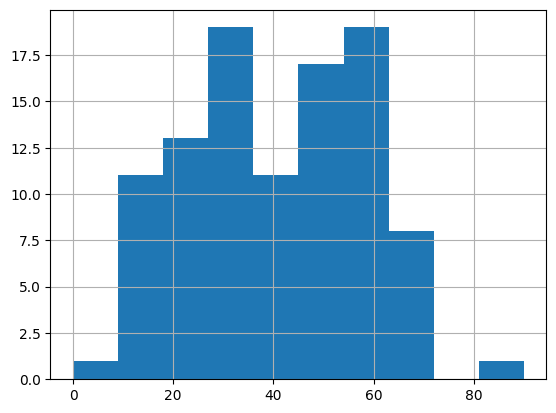

In [14]:
df2['age'].hist();

Achieving the optimal generalization for $k$-Anonymity is very challenging in cases like this. Generalizing each row *more* would be overkill for the well-represented individuals with ages in the 20-40 range, and would hurt utility. However, more generalization is clearly needed for individuals at the upper and lower ends of the age range. This is the kind of challenge that occurs regularly in practice, and is difficult to solve automatically. In fact, optimal generalization for $k$-Anonymity has been shown to be NP-hard.

```{important}
Outliers make achieving $k$-Anonymity very challenging, even for large datasets. Optimal generalization for $k$-Anonymity is NP-hard.
```

## Removing Outliers

One solution to this problem is simply to clip the age of each individual in the dataset to lie within a specific range, eliminating outliers entirely. This can also hurt utility, since it replaces real ages with fake ones, but it can be better than generalizing each row more. We can use Numpy's `clip` method to perform this clipping. We clip ages to be 10-60, and require an educational level of at least 5th-6th grade (represented by the index $3$ in the dataset).

In [15]:
# clipping away outliers
depths = {
    'age': 1,
    'edu': 1
}
dfp = df.clip(upper=np.array([60, 100000000]), axis='columns')
dfp = dfp.clip(lower=np.array([10, 3]), axis='columns')
df2 = generalize(dfp.head(500), depths)
isKAnonymized(df2, 7)

True

Now, the generalized dataset satisfies $k$-Anonymity for $k=7$! In other words, our level of generalization was appropriate, but outliers prevented us from achieving $k$-Anonymity before, even for $k=2$.

## The Homogeneity Attack

The homogeneity attack represents a significant limitation to the effectiveness of $k$-Anonymity. Ordinarily, the goal of $k$-Anonymity is to protect individuals' identities by ensuring that each individual in a dataset is indistinguishable from at least $k-1$ others. These $k-1$ others (in addition to the individual) are called the individual's "group" *within* the dataset.  

However, the homogeneity attack leverages similarities among quasi-identifiers within a group, making it challenging to achieve true individual anonymity. In this attack, an adversary exploits the *uniformity* or *lack of diversity* among the attributes used for anonymization, enabling the de-anonymization/re-identification of individuals. 

This attack vector arises when the data's quasi-identifiers exhibit a high degree of similarity, and groups have identical values for their sensitive attributes, making it easier for an attacker to infer sensitive information about specific individuals. In such cases, sensitive information regarding individuals can be inferred via determination of group membership. 

```{note}
It is worth noting that $k$-Anonymity is also highly susceptible to attacks enabled by the availability of *background knowledge* regarding individuals. Such knowledge may aid, for example, in re-identification of individuals by simple process of elimination of other members of their group who do not fit certain criteria.
```

Addressing the homogeneity attack requires careful manual consideration regarding the selection of diverse quasi-identifiers, highlighting the need for more sophisticated anonymization techniques to enhance the robustness of privacy preservation in datasets.

One such technique, which is also immune to the presence of background knowledge, is differential privacy.



```{admonition} Summary
- $k$-Anonymity is a property of data, which ensures that each individual "blends in" with a group of at least $k$ individuals.
- $k$-Anonymity is computationally expensive even to check: the naive algorithm is $O(n^2)$, and faster algorithms take considerable space.
- $k$-Anonymity can be achieved by modifying a dataset by *generalizing* it, so that particular values become more common and groups are easier to form.
- Optimal generalization is extremely difficult, and outliers can make it even more challenging. Solving this problem automatically is NP-hard.
```